# **Predicting Myers-Briggs Personality Type From Tweets**

**Table of contents**


1.   Introduction
2.   Dataset
3. Preprocessing the data
3. Neural Network Approach
4. Machine Learning Approach



## Introduction

The Myers–Briggs Type Indicator (MBTI) is a psychological test that attempts to describe the personality of a person based on their answers given on a series of questions. 

A personality type is made up of 4 categories:


*   introversion (I) or extraversion (E)
*   sensing (S) or intuition (N)
*  thinking (T) or feeling (F)
* judging (J) or perceiving (P)

Based on these categories there are 16 personality types such as "INTP", "ESFJ", "ISTJ", etc.



**Possible applications of personality type predictions**



*   More personal user experience (product or content recommendation)
*   More relevant advertisments



## Dataset

We used a [kaggle dataset](https://www.kaggle.com/datasnaek/mbti-type) to attempt to predict personality types based on tweets. The data was collected from [Personality Cafe](https://www.personalitycafe.com). 

It contains 8675 samples. Each sample has two columns, personality type and posts. 

The posts are composed of 50 tweets per user. 

In [ ]:
import pandas as pd
import re
import nltk
from nltk import word_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import string
from string import digits
from collections import defaultdict
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.utils import resample
from scipy.sparse import vstack

from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import seaborn as sns
!pip install python-twitter
import twitter
import pickle

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
dat = pd.read_csv("drive/MyDrive/MBTI/mbti_1.csv")
dat.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [ ]:
types = []
for w in dat["type"]:
  if w not in types:
    types.append(w)
    types.append(str(w).lower())

types[0:5]

['INFJ', 'infj', 'ENTP', 'entp', 'INTP']

In [ ]:

def typeCount(type_list):
  typecount = dict()

  for t in type_list:
    if t not in typecount:
      typecount[t] = 1
    else:
      typecount[t] += 1

  return typecount

tc = typeCount(dat["type"])

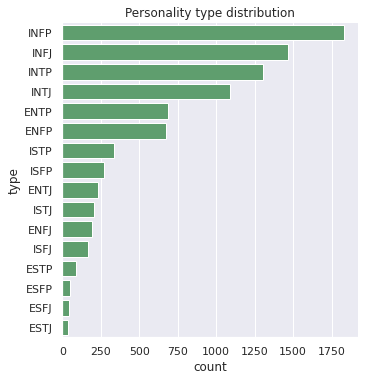

In [ ]:
type_count_df = pd.DataFrame({"type": list(tc.keys()), "count": list(tc.values())})
sns.catplot(x="count", y="type", kind="bar", data=type_count_df.sort_values(['count'], ascending=False), color='g')
plt.title("Personality type distribution")
plt.show()

In [ ]:
# convert labels into binary 
labels = np.zeros((dat.shape[0], 4), int)

for i, tp in enumerate(dat["type"]):
  if tp[0] == "I":
    labels[i, 0] = 1
  if tp[1] == "N":
    labels[i, 1] = 1
  if tp[2] == "F":
    labels[i, 2] = 1
  if tp[3] == "P":
    labels[i, 3] = 1

<BarContainer object of 4 artists>

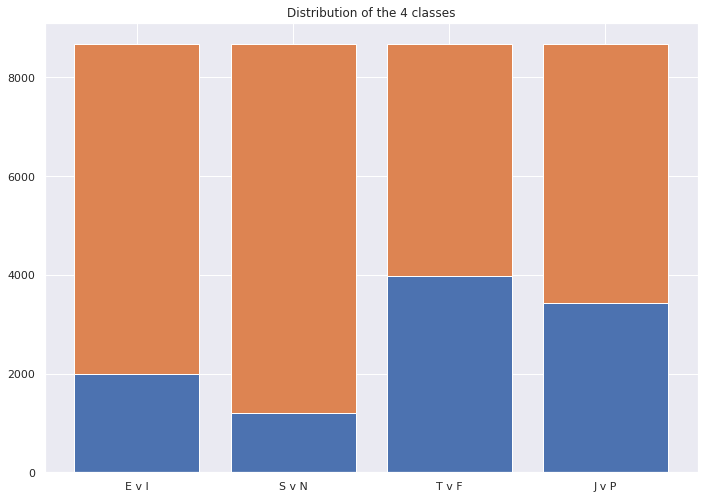

In [ ]:
zeros = [labels[labels[:, i] == 0].shape[0] for i in range(4)]
ones = [labels[labels[:, i] == 1].shape[0] for i in range(4)]

fig, ax = plt.subplots()
plt.title("Distribution of the 4 classes")
ax.bar(["E v I", "S v N", "T v F", "J v P"], zeros)
ax.bar(["E v I", "S v N", "T v F", "J v P"], ones, bottom=zeros)

## Preprocessing the data

In [ ]:
def cleaner(text):
    stops = list(set(stopwords.words('english')))

    #Remove @ sign
    text = re.sub("@[A-Za-z0-9]+","",text)

    # Remove numbers 
    text = re.sub("[0-9]+", "", text)

    # Remove links
    text = re.sub("http[^\s]+", " ", text)
    text = " ".join(text.split())

    # Remove hashtag sign but keep the text
    text = text.replace("#", "").replace("_", " ").replace("|", " ")

    # removing the extra spaces
    text = re.sub(' +', ' ', text) 

    # Remove all punctuation signs
    text = str(text)
    for chr in string.punctuation:
      text = text.replace(chr, " ")

    # Remove words shorter than 3 characters
    text = re.sub(r'\b\w{1,2}\b', '',text)

    # convert words to lowercase and filter stopwords
    text = [w.lower() for w in nltk.wordpunct_tokenize(text) if w not in stops and w not in types]

    return text

In [ ]:
clean_text = dat["posts"].apply(cleaner)
clean_text

0       [moments, sportscenter, top, ten, plays, prank...
1       [finding, lack, posts, alarming, sex, boring, ...
2       [good, one, course, say, know, blessing, curse...
3       [dear, enjoyed, conversation, day, esoteric, g...
4       [you, fired, that, another, silly, misconcepti...
                              ...                        
8670    [always, think, cats, doms, reason, websites, ...
8671    [thread, already, exists, someplace, else, hec...
8672    [many, questions, things, would, take, purple,...
8673    [conflicted, right, comes, wanting, children, ...
8674    [long, since, personalitycafe, although, seem,...
Name: posts, Length: 8675, dtype: object

## Neural Network Approach

The following workflow is present in this notebook section:

  1. Own text cleaning function: removes the links, personality type abbreviations and some punctutations
  2. Text pre-processing with keras Tokenizer(num_words = 1000):

    2.1. The whole dataset was used with One-Hot Encoded labels and

    2.2. Binary labelling of ‘Introversion (I) / Extroversion (E); Intuition (N) – Sensing (S), Feeling (F) - Thinking (T), Judging (J) – Perceiving (P)’ pairs. 
    
    **For these cases relatively small neural networks were trained**

  3. Using the CountVectorizer with **10 000 features based on two types of cleaned text data**.

  4. Binary classifiers for I/E, N/S, F/T, J/P pairs. ==> **Final predictions**

### Method 1. Text pre-processing with keras Tokenizer(num_words = 1000) and One-Hot Encoded Labels

In [ ]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(clean_text)
X = tokenizer.texts_to_matrix(clean_text)

print(X.shape)

In [ ]:
encoder = LabelEncoder()
encoder.fit(dat['type'])
encoded_Y = encoder.transform(dat['type'])
# convert integers to dummy variables (i.e. one hot encoded)
Y = np_utils.to_categorical(encoded_Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1000)
X_train, y_train
print(len(y_train[0]))
print(y_train)

In [ ]:
def defineModel(input_shape, output_length):

  model = models.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape))

  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.1))

  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dropout(0.1))

  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dropout(0.1))

  model.add(layers.Dense(output_length, activation='softmax'))

  return model

In [ ]:
model = defineModel(X_train.shape[1], 16)
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

In [ ]:
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 34.30

### Method 2. Binary labelling of ‘Introversion (I) / Extroversion (E); Intuition (N) – Sensing (S), Feeling (F) - Thinking (T), Judging (J) – Perceiving (P)’ pairs.

In [ ]:
labels = np.zeros((dat.shape[0], 4), int)
labels

for i, tp in enumerate(dat["type"]):
  if tp[0] == "I":
    labels[i, 0] = 1
  if tp[1] == "N":
    labels[i, 1] = 1
  if tp[2] == "F":
    labels[i, 2] = 1
  if tp[3] == "P":
    labels[i, 3] = 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33)

In [ ]:
model2 = defineModel(X_train.shape[1], 4)
model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
print(model2.summary())

In [ ]:
history2 = model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)
_, accuracy = model2.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 20.50

### Method 3. CountVectorizer with 10 000 features based on two types of cleaned text data

#### 3.1. Text cleaning with the function presented above; the labels are One-Hot Encoded

In [ ]:
def cleaner2(text):
    stops = list(set(stopwords.words('english')))
    text = re.sub("@[A-Za-z0-9]+","",text) 
    text = re.sub("http[^\s]+", " ", text)
    text = " ".join(text.split())
    text = text.replace("#", "").replace("_", " ").replace("|", " ")
    text = re.sub(' +', ' ', text) # removing the extra speces
    text = str(text)
    for chr in string.punctuation:
      text = text.replace(chr, " ")
    text = re.sub(r'\b\w{1}\b', '',text)

    text = [w.lower() for w in nltk.wordpunct_tokenize(text) if w not in stops and w not in types]

    return ' '.join(text) 

In [ ]:
dat = pd.read_csv("drive/MyDrive/MBTI/mbti_1.csv")

types=dat['type'].unique()
dat['category']=dat['type'].apply(lambda x: np.where(types==x)[0][0])
dat['posts'].apply(cleaner2)
dat.groupby('category').count()

In [ ]:
xtrain, xtest, ytrain, ytest=train_test_split(dat['posts'],dat['category'],shuffle=True,test_size=0.3, random_state = 4)
print(xtrain.shape, ytrain.shape, xtest.shape, ytest.shape)

In [ ]:
cv=CountVectorizer(max_features=10000,ngram_range=(1,2))
cv.fit(xtrain)
xtrain1=cv.transform(xtrain)
xtest = cv.transform(xtest)

ytrain1=pd.get_dummies(ytrain)
ytrain1 = np.asarray(ytrain1)
ytrain1

In [ ]:
model3= models.Sequential()
model3.add(layers.Dense(500,input_shape=(10000,),activation='relu'))
model3.add(layers.Dropout(0.6))
model3.add(layers.Dense(16,activation='softmax'))
model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history3 = model3.fit(xtrain1,ytrain1,epochs=20)

In [ ]:
ytest = pd.get_dummies(ytest)
model3.evaluate(xtest,np.asarray(ytest))

Accuracy: 0.6285

#### 3.2. Using another text cleaning

This text cleaning function removes the links and stopwords. At the same time, it performs stemming on the words.

In [ ]:
p=PorterStemmer()
stwrds=stopwords.words("english")
def filtr(st):
    arr=[re.sub("http.*","",x) for x in st.split() if x not in stwrds]
    arr=[p.stem(x) for x in arr]
    return ' '.join(arr)

Here I reload the dataframe to be sure that I use the original raw data.

In [ ]:
dat2 = pd.read_csv("drive/MyDrive/MBTI/mbti_1.csv")

dat2.head()

types=dat2['type'].unique()
dat2['category']=dat2['type'].apply(lambda x: np.where(types==x)[0][0])
dat2['posts'].apply(filtr)
dat2.groupby('category').count()

In [ ]:
xtrain,xtest,ytrain,ytest=train_test_split(dat2['posts'],dat2['category'],shuffle=True,test_size=0.3, random_state = 4)
print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

In [ ]:
cv=CountVectorizer(max_features=10000,ngram_range=(1,2))
cv.fit(xtrain)
xtrain1=cv.transform(xtrain)
xtest = cv.transform(xtest)

ytrain1=pd.get_dummies(ytrain)
ytrain1 = np.asarray(ytrain1)
ytrain1

In [ ]:
model4= models.Sequential()
model4.add(layers.Dense(500,input_shape=(10000,),activation='relu'))
model4.add(layers.Dropout(0.6))
model4.add(layers.Dense(16,activation='softmax'))
model4.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history4 = model4.fit(xtrain1,ytrain1,epochs=20)

In [ ]:
ytest = pd.get_dummies(ytest)
model4.evaluate(xtest,np.asarray(ytest))

Accuracy: 0.6135

### Method 4. Binary classifiers for I/E, N/S, F/T, J/P pairs. ==> Final predictions

In this section, we teach a total of four binary classifiers, one classifier for each personality type pair.

For prediction, we place each binarized (rounded to 0 decimal) results one after the other and invert them back to characters.

At the very end, we run the classifiers on the test data, respectively, and calculate the final accuracy from it.

In [ ]:
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    
    return [b_Pers[l] for l in personality]

def translate_back(personality):
    # transform binary vector to mbti personality
    
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

# Check ...
list_personality_bin = np.array([translate_personality(p) for p in dat.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

In [ ]:
# We want to remove these from the psosts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
  
unique_type_list = [x.lower() for x in unique_type_list]


# Lemmatize
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

# Cache the stop words for speed 
cachedStopWords = stopwords.words("english")

def pre_process_data(data, remove_stop_words=True, remove_mbti_profiles=True):

    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0
    
    for row in data.iterrows():
        i+=1
        if (i % 1000 == 0 or i == 1 or i == len_data):
            print("%s of %s rows" % (i, len_data))

        ##### Remove and clean comments
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp).lower()
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
            
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t,"")

        type_labelized = translate_personality(row[1].type)
        list_personality.append(type_labelized)
        list_posts.append(temp)

    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality

In [ ]:
list_posts, list_personality  = pre_process_data(dat2, remove_stop_words=False)

In [ ]:
def _getModel(n_inputs, n_outputs):
  
  model = models.Sequential()
  model.add(layers.Dense(500, input_shape = (n_inputs,), activation='relu'))
  model.add(layers.Dropout(0.6))
  model.add(layers.Dense(1, activation='sigmoid'))
  
  return model

def train_MB_Personality(list_posts, list_personality, path = None, epochs = 10, random_state = 3,save_model = True):
  
  X_train, X_test, y_train, y_test = train_test_split(list_posts,list_personality,shuffle=True,test_size=0.3, random_state = random_state)

  cv = CountVectorizer(max_features = 10000, ngram_range = (1,2))
  cv.fit(X_train)

  X_train_ = cv.transform(X_train)
  X_test_ = cv.transform(X_test)

  # Introversion (I) / Extroversion (E) 
  print("Training IE model...")

  model_ie = _getModel(X_train_.shape[1], 1)

  model_ie.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

  model_ie.fit(X_train_, y_train[:, 0], epochs = epochs)
  model_ie.evaluate(X_test_,np.asarray(y_test[:, 0]))

  if save_model == True: 
    p = [path, "I_E_model"]
    p = "".join(p)
    model_ie.save(p)

  # Intuition (N) – Sensing (S)
  print("Training NS model...")
  
  model_ns = _getModel(X_train_.shape[1], 1)
  model_ns.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  model_ns.fit(X_train_, y_train[:, 1], epochs = epochs)
  model_ns.evaluate(X_test_,np.asarray(y_test[:, 1]))

  if save_model == True: 
    p = [path, "N_S_model"]
    p = "".join(p)
    model_ns.save(p)

  # Feeling (F) - Thinking (T)
  print("Training FT model...")
  
  model_ft = _getModel(X_train_.shape[1], 1)
  model_ft.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  model_ft.fit(X_train_, y_train[:, 2], epochs = epochs)
  model_ft.evaluate(X_test_,np.asarray(y_test[:, 2]))
  
  if save_model == True: 
    p = [path, "F_T_model"]
    p = "".join(p)
    model_ft.save(p)

  # Judging (J) – Perceiving (P)
  print("Training JP model...")

  model_jp = _getModel(X_train_.shape[1], 1)
  model_jp.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  model_jp.fit(X_train_, y_train[:, 3], epochs = epochs, validation_data = (X_test_, y_test[:, 3]))
  model_jp.evaluate(X_test_,np.asarray(y_test[:, 3]))
  
  if save_model == True: 
    p = [path, "J_P_model"]
    p = "".join(p)
    model_jp.save(p)

  return model_ie, model_ns, model_ft, model_jp

model_ie, model_ns, model_ft, model_jp = train_MB_Personality(list_posts, list_personality,path = None, epochs = 15, random_state = 3, save_model = False)

**Evaluation loss and accuracy values:**

1.   Introversion (I) / Extroversion (E)    **L = 1.0261; Acc = 0.7833**  
2.   Intuition (N) – Sensing (S)            **L = 0.6150; Acc = 0.8494**
3.   Feeling (F) - Thinking (T)             **L = 0.9102; Acc = 0.7630**
4.   Judging (J) – Perceiving (P)           **L = 1.2936; Acc = 0.6362**

**Pay attention to the random state.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(list_posts,list_personality,shuffle=True,test_size=0.3, random_state = 3)

cv = CountVectorizer(max_features = 10000, ngram_range = (1,2))
cv.fit(X_train)

In [ ]:
NR = 2
test_tweet = list_posts[NR]
test_label = list_personality[NR]

print(test_tweet)
print(test_label)


prep_test_text = cv.transform([test_tweet])

In [ ]:
def predictPersonality(prepared_text, model_ie = model_ie, model_ns = model_ns, model_ft = model_ft, model_jp = model_jp):
  p_ie = model_ie.predict(prepared_text)
  p_ns = model_ns.predict(prepared_text)
  p_ft = model_ft.predict(prepared_text)
  p_jp = model_jp.predict(prepared_text)
  
  predicted = [round(p_ie[0][0]),  round(p_ns[0][0]), round(p_ft[0][0]), round(p_jp[0][0])]

  return predicted

predicted = predictPersonality(prep_test_text)
print(f"The predicted personality type: {translate_back(predicted)}")
print(f"The original personality type: {dat.type[NR]}")

**Final predictions and accuracy calculation**

In [ ]:
x_test_final = cv.transform(X_test)
y_hat = []
for txt in x_test_final:
  y_hat.append(predictPersonality(txt))

accuracy = accuracy_score(y_test, y_hat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 32.69

### Summary of Neural Network Approach

1. We obtained the largest accuracy values (0.6285 and 0.6135) with the Method 3.1 and 3.2. We note that these two methods differ in the text cleaning function.

2. Among the binary classifiers, Intuition-Sensing achieved the highest accuracy (0.8494).

## Machine Learning Approach

In [ ]:
# create tfidf representation of the data
txts = [" ".join(ls) for ls in clean_text]
tfidf = TfidfVectorizer()
tfidf.fit(txts)
res = tfidf.transform(txts)

In [ ]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(res, labels, test_size=0.3)

In [ ]:
# search for optimal parameters of a model type for every
# classification task
def get_best_model_combination(model, X, y, params):
  models = [None] * 4
  for i in range(4):
    print("Starting model {}".format(i+1))

    md = model()
    cv = RandomizedSearchCV(md, params, n_iter=15, scoring=make_scorer(f1_score), verbose=5, n_jobs=4, cv=3)
    cv.fit(X, y[:, i])

    print("Best score: {}".format(cv.best_score_))

    md.set_params(**cv.best_params_)
    models[i] = md

  return models

In [ ]:
xgb_possible_params = {
    "eta": [0.2, 0.3, 0.4],
    "max-depth": [5, 6],
    "subsample": [0.9, 1]
}

xgb_models = get_best_model_combination(XGBClassifier, X_train, y_train, xgb_possible_params)

In [ ]:
random_forest_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 3, 6, 9],
    "class_weight": ["balanced"],
    "min_samples_split": [2, 3]
}

rf_models = get_best_model_combination(RandomForestClassifier, X_train, y_train, random_forest_params)

In [ ]:
# train and save models to pickle files
def save_models(models, model_names, X, y):
  for i, model in enumerate(models):
    model.fit(X, y[:, i])
    pickle.dump(model, open("model_{}_{}.pickle.dat".format(model_names, i+1), "wb"))

In [ ]:
save_models(xgb_models, "xgb", X_train, y_train)

In [ ]:
save_models(rf_models, "rf", X_train, y_train)

In [ ]:
# load models from pickle files
def load_models(model_name, path):
  models_ = []
  for i in range(4):
    model = pickle.load(open(path + "model_{}_{}.pickle.dat".format(model_name, i+1), "rb"))
    models_.append(model)
  return models_

In [ ]:
# validate models on the test dataset
def validate(models, X, y):
  for i, model in enumerate(models):
    y_pred = model.predict(X)
    print("{}. predictor f1 score: {}".format((i+1), f1_score(y[:, i], y_pred)))

In [ ]:
models_ = load_models("rf", "./")
validate(models_, X_test, y_test)

1. predictor f1 score: 0.873891412502704
2. predictor f1 score: 0.9261246388774246
3. predictor f1 score: 0.7659176029962547
4. predictor f1 score: 0.7454455933037912


In [ ]:
models_ = load_models("xgb", "./")
validate(models_, X_test, y_test)

1. predictor f1 score: 0.8631161971830986
2. predictor f1 score: 0.9338250358533087
3. predictor f1 score: 0.7657625924621346
4. predictor f1 score: 0.7464534433840598


In [ ]:
# predict label for a single instance
def predict(models, X):
  predictions = np.array([0] * 4)
  for i in range(len(models)):
    predictions[i] = models[i].predict(X)
  return predictions

In [ ]:
# convert label from binary to text
def label_decode(label):
  lab = ""
  decode_dict = {0: ["E", "I"], 1: ["S", "N"], 2: ["T", "F"], 3: ["J", "P"]}

  for i in range(len(label)):
    lab += decode_dict[i][label[i]]

  return lab

### Feature importances

#### Extraversion (E) – Introversion (I) 

In [ ]:
importances = models_[0].feature_importances_
imp_feat_idxs = np.argsort(importances)[-20:][::-1]
words = []

for idx in imp_feat_idxs:
  for key in tfidf.vocabulary_.keys():
    if tfidf.vocabulary_[key] == idx:
      words.append(key)

In [ ]:
words

['guys',
 'lol',
 'you',
 'fun',
 'get',
 'super',
 'world',
 'love',
 'like',
 'one',
 'the',
 'human',
 'awesome',
 'friends',
 'definitely',
 'feel',
 'know',
 'mind',
 'well',
 'family']

#### Sensing (S) – Intuition (N) 

In [ ]:
importances = models_[1].feature_importances_
imp_feat_idxs = np.argsort(importances)[-20:][::-1]
words = []

for idx in imp_feat_idxs:
  for key in tfidf.vocabulary_.keys():
    if tfidf.vocabulary_[key] == idx:
      words.append(key)

words

['think',
 'world',
 'feel',
 'type',
 'human',
 'one',
 'people',
 'pretty',
 'the',
 'get',
 'car',
 'idea',
 'always',
 'yes',
 'love',
 'way',
 'know',
 'cool',
 'done',
 'something']

#### Thinking (T) – Feeling (F) 

In [ ]:
importances = models_[2].feature_importances_
imp_feat_idxs = np.argsort(importances)[-20:][::-1]
words = []

for idx in imp_feat_idxs:
  for key in tfidf.vocabulary_.keys():
    if tfidf.vocabulary_[key] == idx:
      words.append(key)

words

['feel',
 'love',
 'really',
 'feeling',
 'beautiful',
 'thank',
 'think',
 'felt',
 'much',
 'sometimes',
 'heart',
 'happy',
 'life',
 'know',
 'lot',
 'like',
 'little',
 'relate',
 'use',
 'glad']

#### Judging (J) – Perceiving (P)

In [ ]:
importances = models_[3].feature_importances_
imp_feat_idxs = np.argsort(importances)[-20:][::-1]
words = []

for idx in imp_feat_idxs:
  for key in tfidf.vocabulary_.keys():
    if tfidf.vocabulary_[key] == idx:
      words.append(key)

words

['fun',
 'music',
 'love',
 'really',
 'like',
 'pretty',
 'yeah',
 'the',
 'someone',
 'say',
 'others',
 'thing',
 'well',
 'person',
 'think',
 'people',
 'type',
 'much',
 'see',
 'one']

### Twitter test

In [ ]:
twitter_api = twitter.Api(consumer_key='',
                          consumer_secret='',
                          access_token_key='',
                          access_token_secret='')

In [ ]:
def predict_twitter_user(twitter_api, user_id, models, vectorizer):
  # get last 50 posts from a user
  for i in range(10):
    tweets = twitter_api.GetUserTimeline(count=(i + 1) * 50, user_id=user_id, include_rts=False, exclude_replies=True)
    if len(tweets) >= 50:
      break

  # prepare text
  tweet_text = [t.text for t in tweets[:50]]
  tweet_text = " ".join(tweet_text)
  clean_tweet = " ".join(cleaner(tweet_text))
  tw_res = vectorizer.transform([clean_tweet])

  # predict and decode label
  return label_decode(predict(models, tw_res))

In [ ]:
ttest = pd.read_csv("twitter_test.csv")
ttest

,user_id,type
0,2969193063,intp
1,1117191121220898816,intp
2,3298638792,intp
3,35391321,intp
4,3234730002,intp
5,788361894130290688,intp
6,1260747791409823746,intp
7,3365416901,intp
8,1007825198475669504,intp
9,816466526140305408,intp


In [ ]:
ttest["predicted"] = ""
for row in ttest.iterrows():
  label = predict_twitter_user(twitter_api, row[1][0], models_, tfidf)
  ttest.loc[row[0], "predicted"] = label

ttest

,user_id,type,predicted
0,2969193063,intp,INFP
1,1117191121220898816,intp,INTP
2,3298638792,intp,INTP
3,35391321,intp,INFP
4,3234730002,intp,ISFP
5,788361894130290688,intp,INFP
6,1260747791409823746,intp,INTP
7,3365416901,intp,INFP
8,1007825198475669504,intp,INFP
9,816466526140305408,intp,INTP
